In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'

### Dependencies

In [0]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
#@title
from keras.optimizers import Optimizer

class AdamAccumulated(Optimizer):
    """Adam optimizer with gradient accumulation.
    Default parameters follow those provided in the original paper.
    # Arguments
        accumulation_steps: int > 0. Update gradient in every accumulation steps.
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, accumulation_steps, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, **kwargs):
        super(AdamAccumulated, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.accumulation_steps = K.variable(accumulation_steps, dtype='int64', name='accumulation_steps')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        update_cond = K.equal((self.iterations + 1) % self.accumulation_steps, 0)
        sub_step = self.iterations % self.accumulation_steps + 1
        t = K.cast(self.iterations // self.accumulation_steps, K.floatx()) + 1

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))
        lr_t = K.switch(update_cond, lr_t, 0.0)

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]
        self.weights = [self.iterations] + ms + vs + vhats

        acc_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        for grad, acc_grad in zip(grads, acc_grads):
            ave_grad = grad / K.cast(self.accumulation_steps, K.floatx())
            self.updates.append(K.update(
                acc_grad,
                K.switch(
                    K.equal(sub_step, 1),
                    ave_grad,
                    acc_grad + (ave_grad - acc_grad) / K.cast(sub_step, K.floatx())
                ),
            ))
        grads = [K.switch(update_cond, grad, K.zeros_like(grad)) for grad in acc_grads]

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = K.switch(update_cond, (self.beta_1 * m) + (1. - self.beta_1) * g, m)
            v_t = K.switch(update_cond, (self.beta_2 * v) + (1. - self.beta_2) * K.square(g), v)
            if self.amsgrad:
                vhat_t = K.switch(update_cond, K.maximum(vhat, v_t), vhat)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'accumulation_steps': int(K.get_value(self.accumulation_steps)),
                  'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulated, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/classification/'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_dest_path = 'train_images/'

### Load data

In [0]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,0,0,0,1,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,1,1,0,0,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train


# Model parameters

In [0]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
EPOCHS = 20 #30
LEARNING_RATE = 1e-4 #3e-3
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.2
ACC_STEPS = 8
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

model_name = '61-unet_%s_%sx%s' % (BACKBONE, HEIGHT, WIDTH)
model_path = model_base_path + '%s.h5' % (model_name)

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, 
                                                   shift_limit=0.1, border_mode=0, p=0.5)
                            ])

### Data generator

In [0]:
train_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model

In [0]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = AdamAccumulated(lr=LEARNING_RATE, accumulation_steps=ACC_STEPS)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
# model.summary()

In [0]:
model.load_weights(model_path)

In [0]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

Epoch 1/30
552/552 [==============================] - 1004s 2s/step - loss: 0.9990 - dice_coef: 0.3791 - iou_score: 0.2343 - f1-score: 0.3671 - val_loss: 1.0302 - val_dice_coef: 0.4797 - val_iou_score: 0.3142 - val_f1-score: 0.4617
Epoch 2/30
552/552 [==============================] - 922s 2s/step - loss: 0.8872 - dice_coef: 0.4491 - iou_score: 0.2900 - f1-score: 0.4377 - val_loss: 1.0089 - val_dice_coef: 0.4524 - val_iou_score: 0.2637 - val_f1-score: 0.3970
Epoch 3/30
552/552 [==============================] - 914s 2s/step - loss: 0.8670 - dice_coef: 0.4640 - iou_score: 0.3021 - f1-score: 0.4515 - val_loss: 0.8438 - val_dice_coef: 0.5057 - val_iou_score: 0.3221 - val_f1-score: 0.4699
Epoch 4/30
552/552 [==============================] - 917s 2s/step - loss: 0.8527 - dice_coef: 0.4736 - iou_score: 0.3095 - f1-score: 0.4599 - val_loss: 0.9815 - val_dice_coef: 0.4567 - val_iou_score: 0.2799 - val_f1-score: 0.4184
Epoch 5/30
552/552 [==============================] - 914s 2s/step - loss: 

In [0]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history



Epoch 1/20
552/552 [==============================] - 971s 2s/step - loss: 0.7784 - dice_coef: 0.5243 - iou_score: 0.3533 - f1-score: 0.5088 - val_loss: 0.7604 - val_dice_coef: 0.5563 - val_iou_score: 0.3695 - val_f1-score: 0.5237
Epoch 2/20
552/552 [==============================] - 916s 2s/step - loss: 0.7691 - dice_coef: 0.5283 - iou_score: 0.3572 - f1-score: 0.5139 - val_loss: 0.7625 - val_dice_coef: 0.5578 - val_iou_score: 0.3697 - val_f1-score: 0.5220
Epoch 3/20
552/552 [==============================] - 914s 2s/step - loss: 0.7705 - dice_coef: 0.5274 - iou_score: 0.3566 - f1-score: 0.5125 - val_loss: 0.7613 - val_dice_coef: 0.5577 - val_iou_score: 0.3714 - val_f1-score: 0.5253

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/20
552/552 [==============================] - 916s 2s/step - loss: 0.7670 - dice_coef: 0.5286 - iou_score: 0.3581 - f1-score: 0.5141 - val_loss: 0.7606 - val_dice_coef: 0.5590 - val_iou_score: 0.3710 - val_f1-score:

## Model loss graph

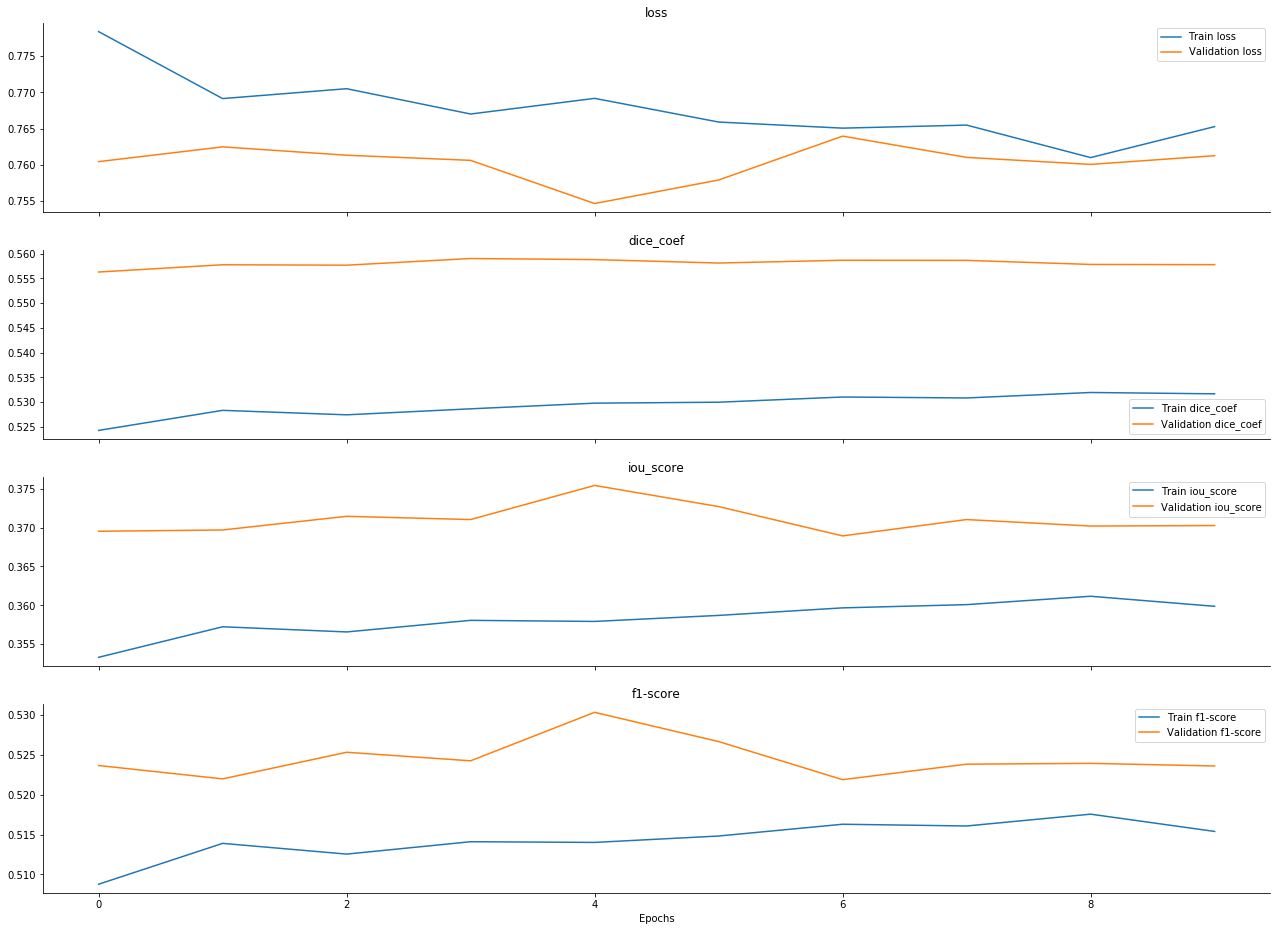

In [0]:
#@title
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])